In [ ]:
import numpy as np
from numpy.core.numeric import cross
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt 

#Upload the document in pandas
data = pd.read_csv('https://advait-chirmule.github.io/AirPollution/city_day.csv')
pd.options.display.max_columns = None
print(data.head(5))
data = data.loc[((data['City'] == 'Ahmedabad') | (data['City'] == 'Bengaluru') | (data['City'] == 'Chennai') 
 | (data['City'] == 'Delhi') | (data['City'] == 'Hyderabad') | (data['City'] == 'Lucknow') | (data['City'] == 'Mumbai'))]


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def CorrectTime(data):
    for i in range(len(data[7])):
        change = datetime.strptime(data.loc[i,7], '%d/%m/%Y')
        data.loc[i,7] = change.strftime('%m/%d/%Y')
    return data

#Create datesave which has FULL data
datesave = None
def PreProcessing1(data):
  #Change the Good, Moderate into numbers
  rating = {'Good': 1, 'Moderate': 2, 'Satisfactory': 3, 'Poor': 4, 'Very Poor': 5, 'Severe': 6}
  data['AQI_Bucket'] = data['AQI_Bucket'].replace(rating)
  #Do One Hot Encoding on the Cities
  city = ColumnTransformer([('City', OneHotEncoder(), [0])], remainder='passthrough')
  data = city.fit_transform(data)
  #Convert back to DataFrame, has columns as numbers
  data = pd.DataFrame(data)
  #Change time from ddmmyyyy to mmddyyyy
  CorrectTime(data)
  datesave = data.copy()
  data[7] = pd.to_datetime(data[7])
  datesave[30] = pd.DatetimeIndex(data[7]).day
  datesave[31] = pd.DatetimeIndex(data[7]).month
  datesave[32] = pd.DatetimeIndex(data[7]).year
  monthdays = {1:31, 2:29, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
  datesave[33] = datesave[31].replace(monthdays)
  datesave[30] = datesave[30].astype(float)
  datesave[31] = datesave[31].astype(float)
  datesave[33] = datesave[33].astype(float)
  for i in range(len(datesave[33])):
      datesave.loc[i,34] = datesave.loc[i,31] + datesave.loc[i,30]/datesave.loc[i,33]
  return data, datesave

data, datesave = PreProcessing1(data)
data = data.drop(columns=21)
data0 = data.copy()
datasave = data.copy()
data0[7] = datesave[34]

        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  01/01/2015    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  02/01/2015    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  03/01/2015    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  04/01/2015    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  05/01/2015    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  


In [ ]:
#(A) LinearRegression
def ReduceDimension(data):
    from sklearn.decomposition import PCA
    pca = PCA()
    reduce = pca.fit_transform(data)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.show()
    #After plotting, we see 5 gives good variance
    pca = PCA(n_components = 5)
    data = pca.fit_transform(data)
    data = pd.DataFrame(data)
    return data

def ScaleData(data):
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    y = data.loc[:, 20]
    data = data.loc[:, :19]
    data = sc.fit_transform(data)
    data = pd.DataFrame(data)
    data[20] = y
    return data

def Linear(data):
    from sklearn.preprocessing import StandardScaler
    
    #data = ScaleData(data)
    #We see Standard Scaler doesn't make a lot of difference as most of our data is a small two digit number
    x = data.drop(columns=20)
    y = data.loc[:, 20]
    #x = ReduceDimension(x)
    #We notice Reducing Dimension didn't do our model much good, meaning the model wasn't overfitted not had correlated features
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)
       
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import accuracy_score
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(mean_absolute_error(y_test, y_pred))

#Very basic LinearRegression model with no date and removing all the rows with missing data
data = data.dropna()
data = data.reset_index(drop=True)

data1 = data.drop(columns=7)
print("Linear Regression with deleted date gives: ") 
Linear(data1)

#Added date to the above model but took only the month number
data2 = data.copy()
datesave2 = datesave.copy()
datesave2 = datesave2.dropna()
datesave2 = datesave2.reset_index(drop=True)

data2[7] = pd.to_datetime(data2[7])
data2[7] = pd.DatetimeIndex(data2[7]).month
print("Linear Regression with month number taken gives: ") 
Linear(data2)

#Added day as a decimal point to the month to the above model
data4 = data2.copy()
data4[7] = datesave2[34]
print("Linear Regression with month and day in decimal gives: ") 
data4 = pd.DataFrame(data4)
Linear(data4)

#Take mean for Missing Data
def MissingMean(data):
  for i in range(8, 20):
    data[i].fillna(data[i].mean(), inplace=True)
  data = pd.DataFrame(data)
  return data

data5 = data0.copy()
data5 = data5.dropna(subset=[20])
data5 = MissingMean(data5)
data5 = data5.reset_index(drop=True)
print("All the data with forward/backward fill applied as long as AQI exists: ")
Linear(data5)

#Drop rows with more than three columns missing
data6 = data0.copy()
data6 = data6.dropna(subset=[20])
data6 = data6.dropna(thresh=18)
data6 = MissingMean(data6)
data6 = data6.reset_index(drop=True)
print("Same model as above but shouldn't have more than 3 columns empty: ")
Linear(data6)

Linear Regression with deleted date gives: 
19.843117045927556
Linear Regression with month number taken gives: 
19.834646864077666
Linear Regression with month and day in decimal gives: 
19.835045575973126
All the data with forward/backward fill applied as long as AQI exists: 
34.76587833450103
Same model as above but shouldn't have more than 3 columns empty: 
32.25729708500146


In [ ]:
#(B) SVR
from sklearn.model_selection import GridSearchCV

def SVR(data):
    x = data.drop(columns=20)
    y = data.loc[:, 20]
    y = y.astype('int')
    #We faced a bad prediction for SVR so let's try reducing dimensions here EDIT: NOPE
    #x = ReduceDimension(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

    from sklearn.svm import SVR
    
    #param_grid={'C': [0.1, 1, 10, 100], 'gamma': [500, 100, 10, 1], 'kernel': ['rbf', 'linear']}
    #grid = GridSearchCV(SVR(), param_grid, verbose=3)
    #grid.fit(x_train, y_train)
    #print(grid.best_params_)

    #We get best parameters as kernel = linear, C = 1, Gamma = 500
    model = SVR(kernel='linear', C = 1, gamma = 500)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(mean_absolute_error(y_test, y_pred))

#Using SVR, all empty rows dropped
data7 = data0.copy()
data7 = data7.dropna()
data7 = data7.reset_index(drop=True)
data7 = data7.astype(float)

print("Using SVR on rows with all data: ")
SVR(data7)

#Using SVM, using the pre processed model above
data8 = data6.copy()
print("Using SVR on the preprocessed data above: ")
SVR(data8)

Using SVR on rows with all data: 
18.513109621929335
Using SVR on the preprocessed data above: 
30.141911477321827


K Neighbors for rows with all data: 
[18.377855887521967, 20.07029876977153, 21.486818980667838, 22.956063268892795, 23.72407732864675, 23.866432337434095, 24.363796133567664, 24.41476274165202, 24.149384885764498, 24.50615114235501, 24.829525483304042, 24.91388400702988, 24.671353251318102, 24.261862917398947, 24.0298769771529, 23.421792618629173, 22.74340949033392, 22.66432337434095, 22.9402460456942, 22.717047451669597, 22.58523725834798, 22.263620386643233, 22.084358523725836, 21.9701230228471, 22.007029876977153, 22.10896309314587, 22.263620386643233, 22.597539543057998, 22.804920913884008, 22.550087873462214, 22.397188049209138, 22.323374340949034, 22.309314586994727, 22.381370826010546, 22.479789103690685, 22.68541300527241, 22.532513181019333, 22.86115992970123, 23.07205623901582]
K Neighbors for preprocessed data above: 
[33.784586815227485, 33.340297121634165, 37.357474466109565, 40.576137418755806, 43.710306406685234, 45.55199628597957, 47.721448467966574, 49.313834726090995

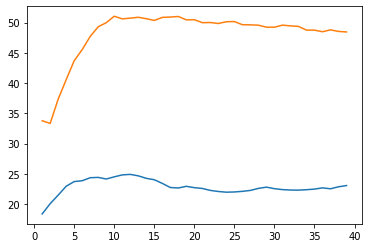

In [ ]:
#(C) Using KNN
def KNN(data):
    error_rate = []
    index = []
    for i in range (1,40):
        index.append(i)
        x = data.drop(columns=20)
        y = data.loc[:, 20]
        y = y.astype('int')
        #Our KNN gave good results so, as thought, reducing dimensions didn't help a lot
        #x = ReduceDimension(x)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

        from sklearn.neighbors import KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(mean_absolute_error(y_test, y_pred))
    
    print(error_rate)
    plt.plot(index, error_rate)
    
    
#Using KNN, all empty rows dropped to find K Neighbors
data9 = data7.copy()
print("K Neighbors for rows with all data: ")
KNN(data9)

#Using KNN, using the pre processed model above to find K Neighbors
data10 = data6.copy()
print("K Neighbors for preprocessed data above: ")
KNN(data10)

In [ ]:
#(C) Applying KNN
def KNN(data, i):
    x = data.drop(columns=20)
    y = data.loc[:, 20]
    y = y.astype('int')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

    from sklearn.neighbors import KNeighborsClassifier
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    print(mean_absolute_error(y_test, y_pred))
    
#Using KNN, all empty rows dropped
data9 = data7.copy()
print("Using KNN on rows with all data: ")
KNN(data7, 1)

#Using KNN, using the pre processed model above
data10 = data6.copy()
print("Using KNN on the preprocessed data above: ")
KNN(data10, 2)

Using KNN on rows with all data: 
18.377855887521967
Using KNN on the preprocessed data above: 
33.340297121634165


In [ ]:
#(D) Using Decision Tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

def DecisionTree(data):
    x = data.drop(columns=20)
    y = data.loc[:, 20]
    y = y.astype('int')
    #x = ReduceDimension(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

    #columns = ['Ahmedabad', 'Bengaluru', 'Chennai', 'Delhi', 'Hyderabad', 'Lucknow', 'Mumbai', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
    #dot_data = export_graphviz(clf, rounded = True, filled = True)
    #graph = pydotplus.graph_from_dot_data(dot_data)
    #graph.write_png("Air_Pollution.png")
    #Image(graph.create_png())

    #grid_param={
    #    'criterion': ['gini', 'entropy'],
    #    'max_depth': range(2, 32, 4),
    #    'min_samples_leaf': range(1, 10, 2),
    #    'min_samples_split': range(2, 10, 2),
    #    'splitter': ['best', 'random']
    #}
    #grid = GridSearchCV(estimator=clf, param_grid = grid_param, cv = 5, verbose=3)
    #grid.fit(x_train, y_train)
    #best_param = grid.best_params_
    #print(best_param)

    clf = DecisionTreeClassifier(criterion= 'gini', max_depth = 6, min_samples_leaf = 9, min_samples_split = 2, splitter = 'best')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("The Mean Absolute Error when applying Decision Tree on half dataset gives: ", mean_absolute_error(y_pred, y_test))

def DecisionTree2(data):
    x = data.drop(columns=20)
    y = data.loc[:, 20]
    y = y.astype('int')
    #x = ReduceDimension(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

    #columns = ['Ahmedabad', 'Bengaluru', 'Chennai', 'Delhi', 'Hyderabad', 'Lucknow', 'Mumbai', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
    #dot_data = export_graphviz(clf, rounded = True, filled = True)
    #graph = pydotplus.graph_from_dot_data(dot_data)
    #graph.write_png("Air_Pollution.png")
    #Image(graph.create_png())

    #Having no parameters is giving the best result
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("The Mean Absolute Error when applying Decision Tree on full dataset gives: ", mean_absolute_error(y_pred, y_test))
    
    #grid_param={
    #    'criterion': ['gini', 'entropy'],
    #    'max_depth': range(2, 32, 4),
    #    'min_samples_leaf': range(1, 10, 2),
    #    'min_samples_split': range(2, 10, 2),
    #    'splitter': ['best', 'random']
    #}
    #grid = GridSearchCV(estimator=clf, param_grid = grid_param, cv = 5, verbose=3)
    #grid.fit(x_train, y_train)
    #best_param = grid.best_params_
    #print(best_param)


data11 = data7.copy()
DecisionTree(data11)

data12 = data6.copy()
DecisionTree2(data12)

The Mean Absolute Error when applying Decision Tree on half dataset gives:  21.738137082601053
The Mean Absolute Error when applying Decision Tree on full dataset gives:  39.94428969359331


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


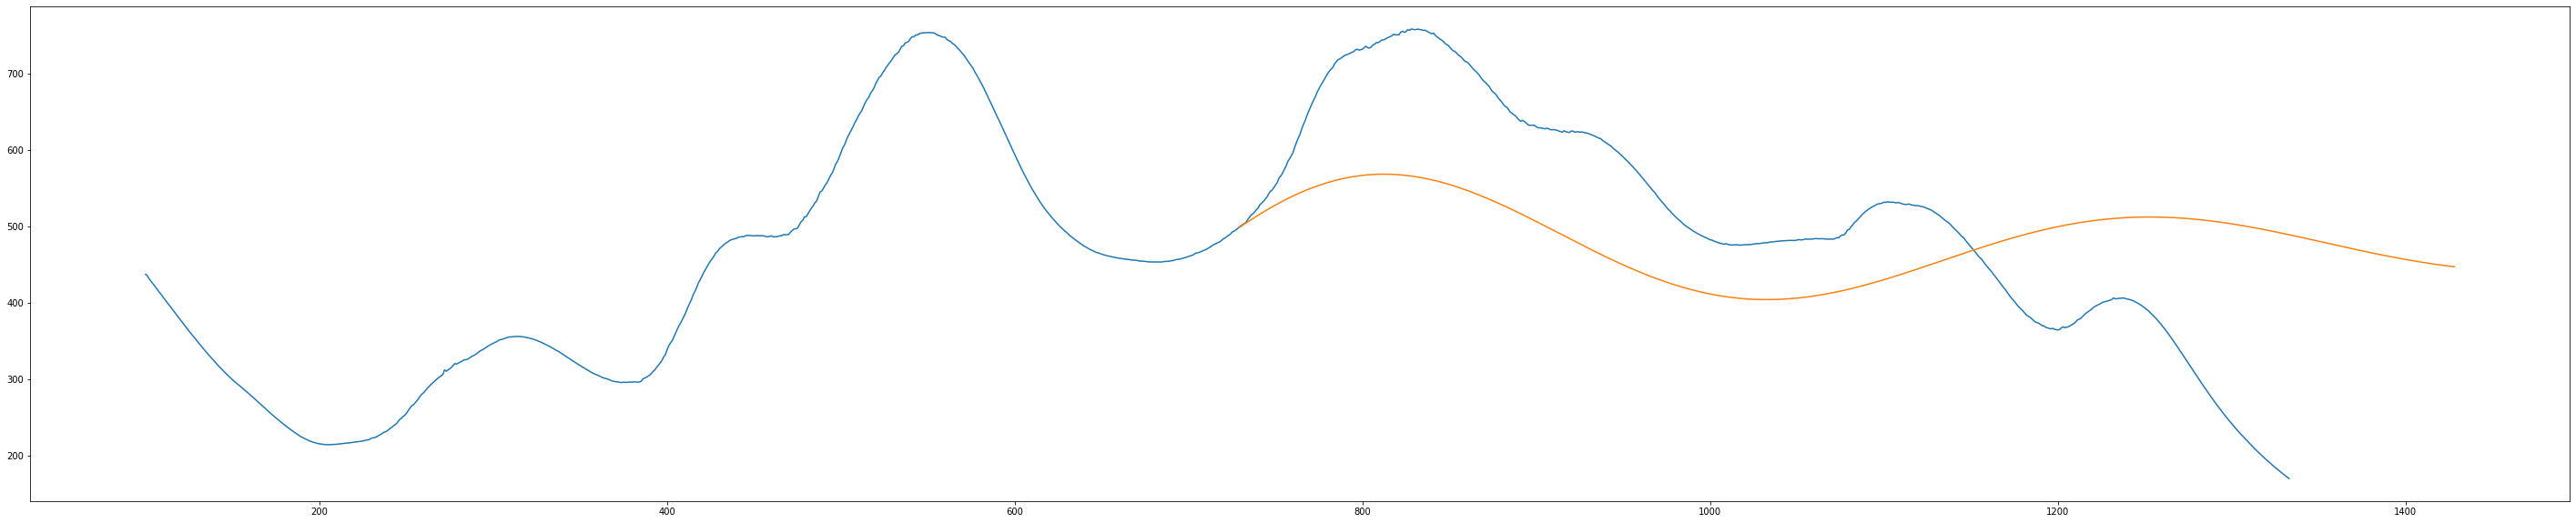

123.63203888962137


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


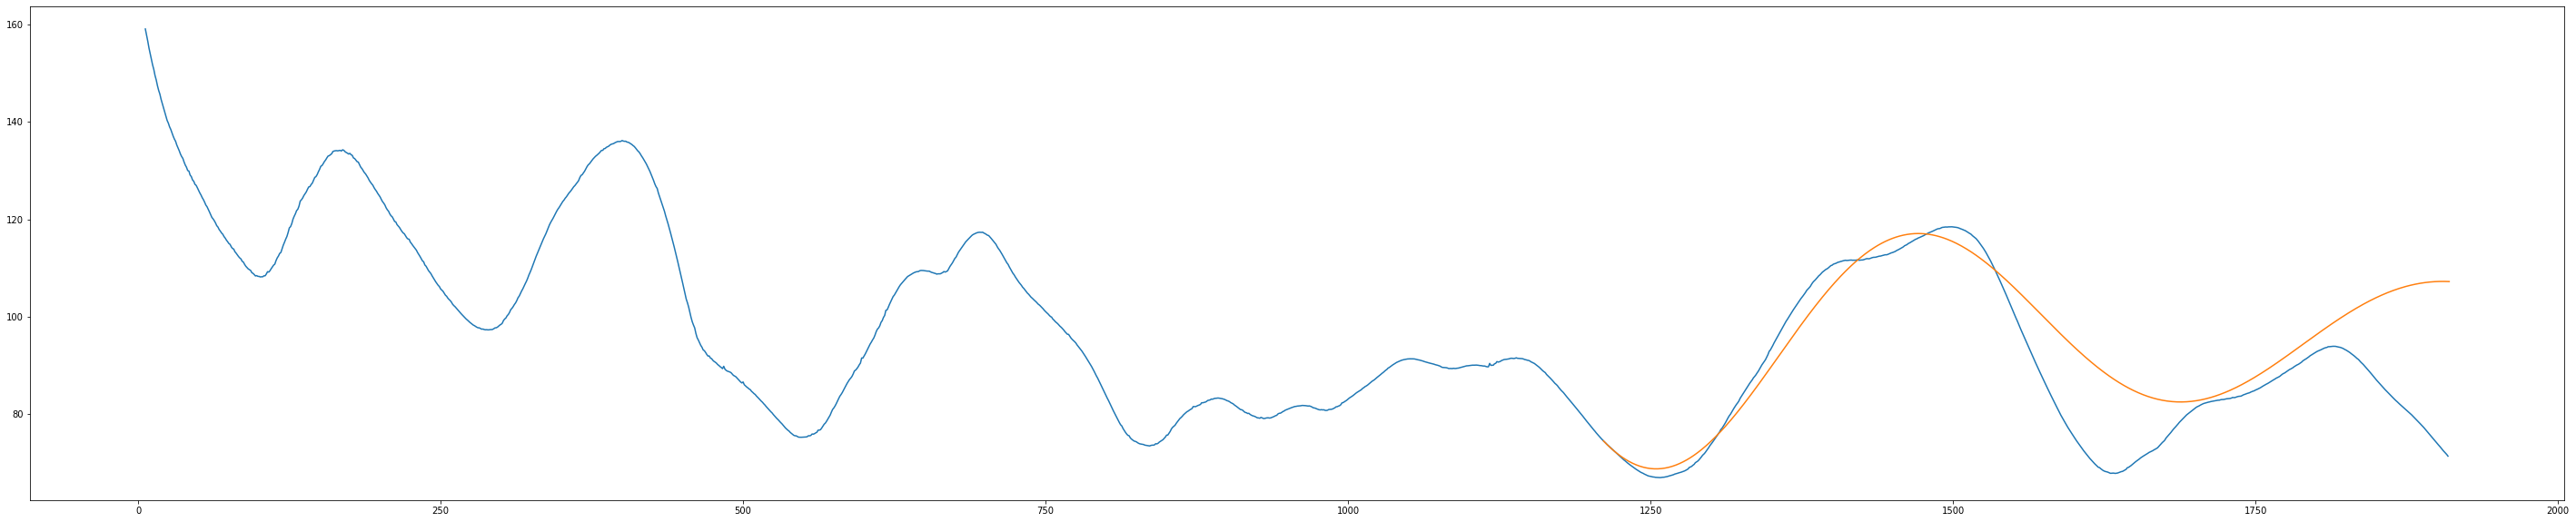

7.130311603188419


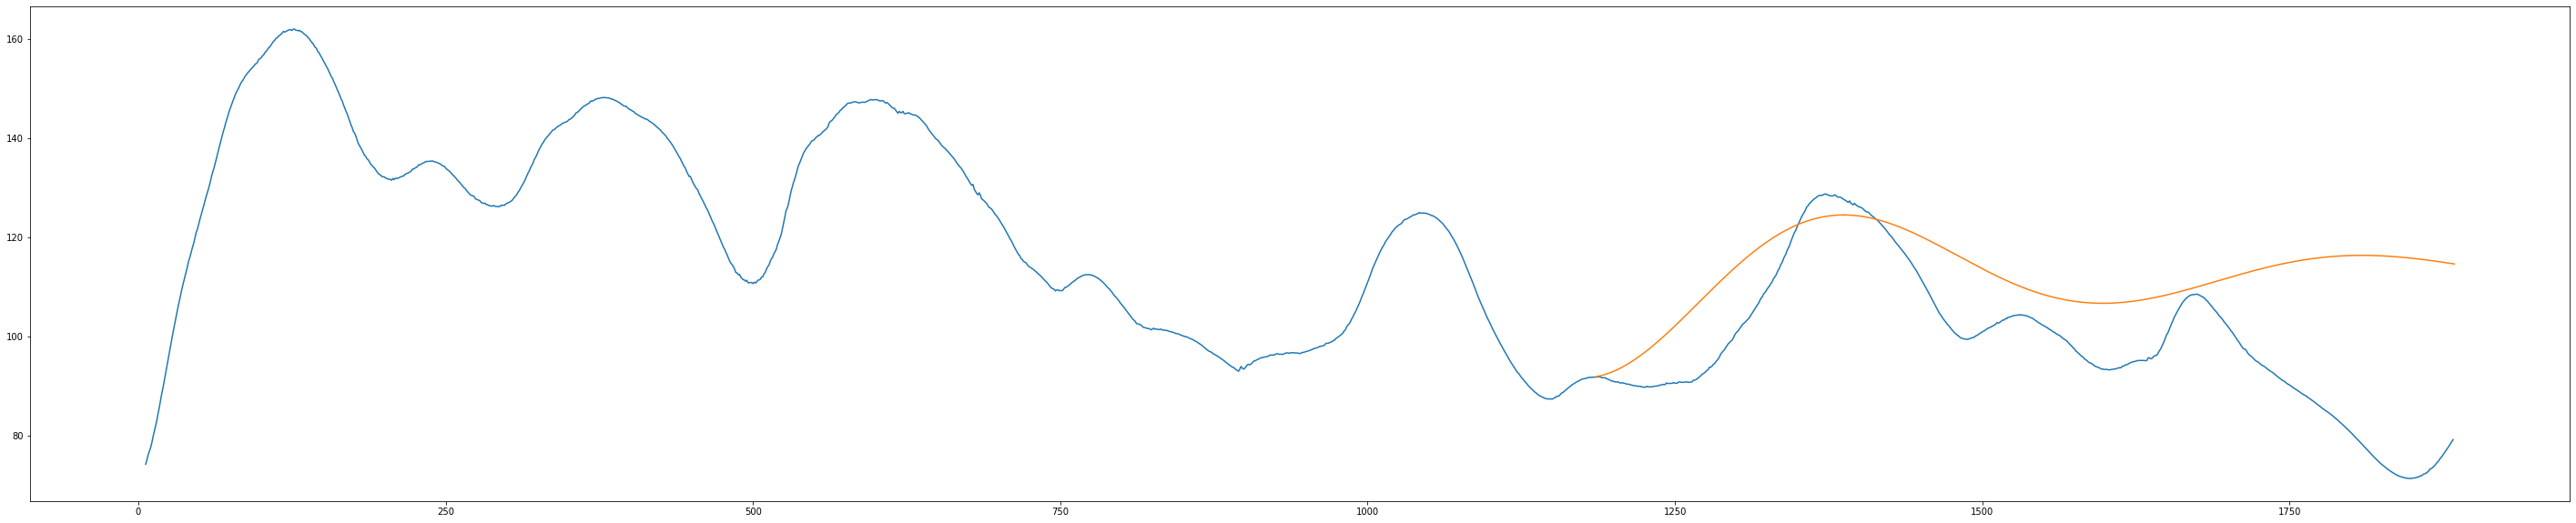

14.401836337250097


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


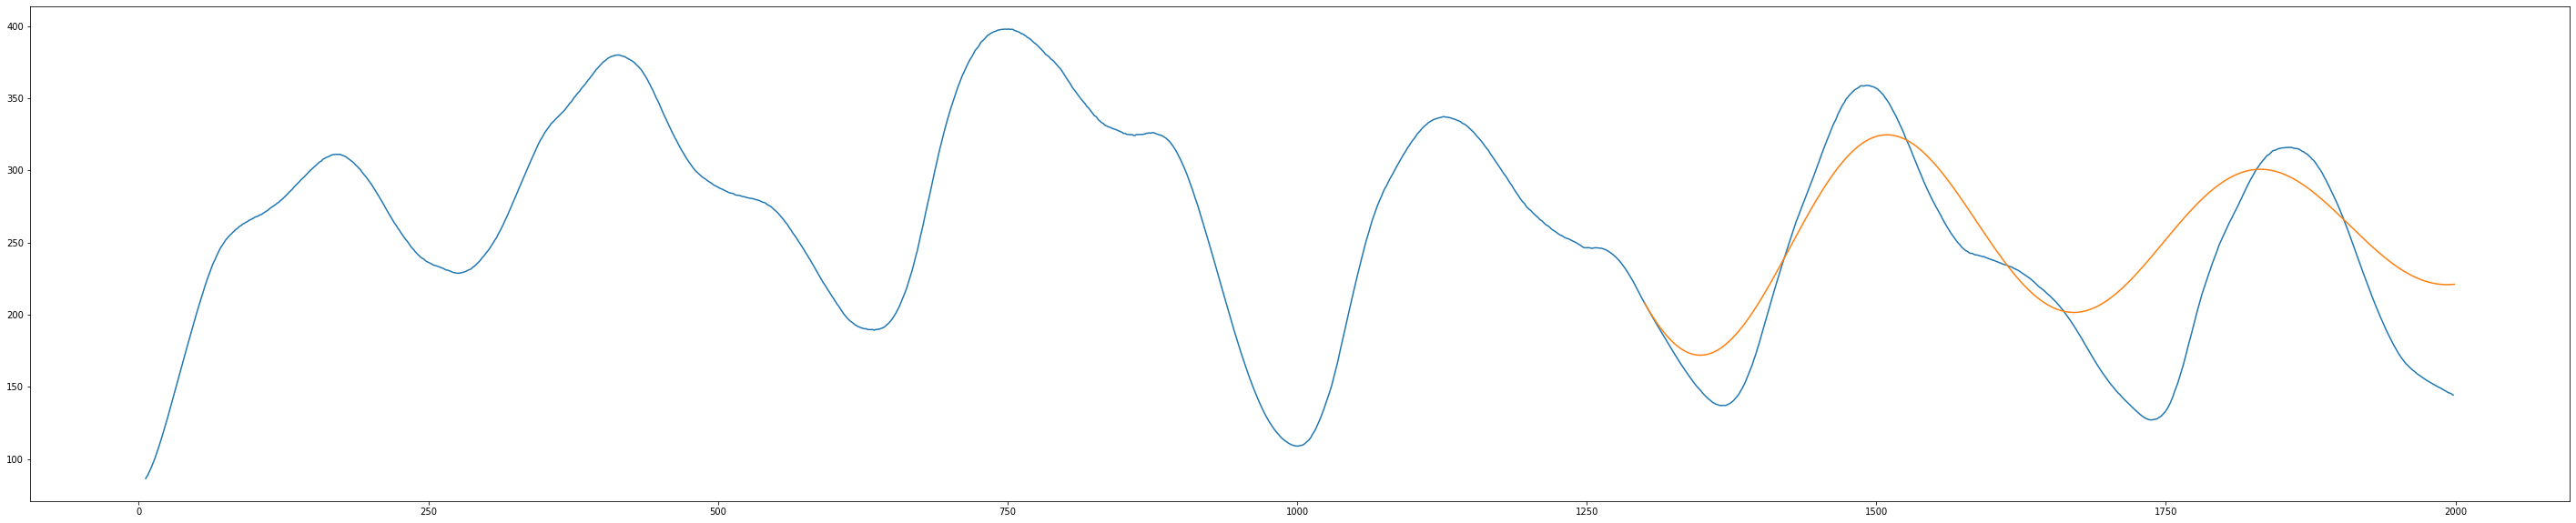

33.4609666968695


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


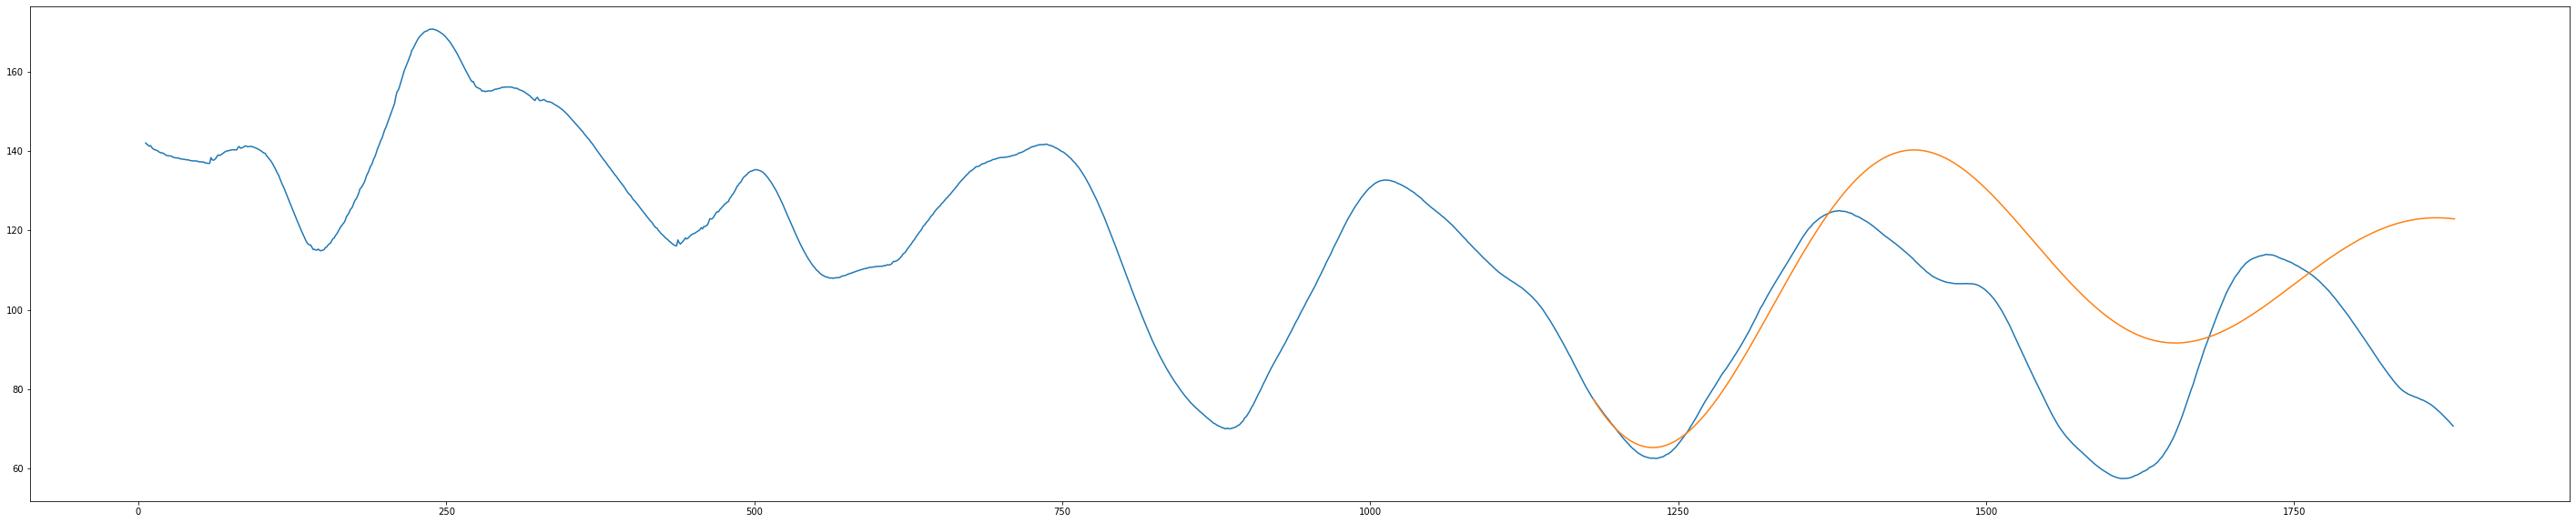

18.62298784505861


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


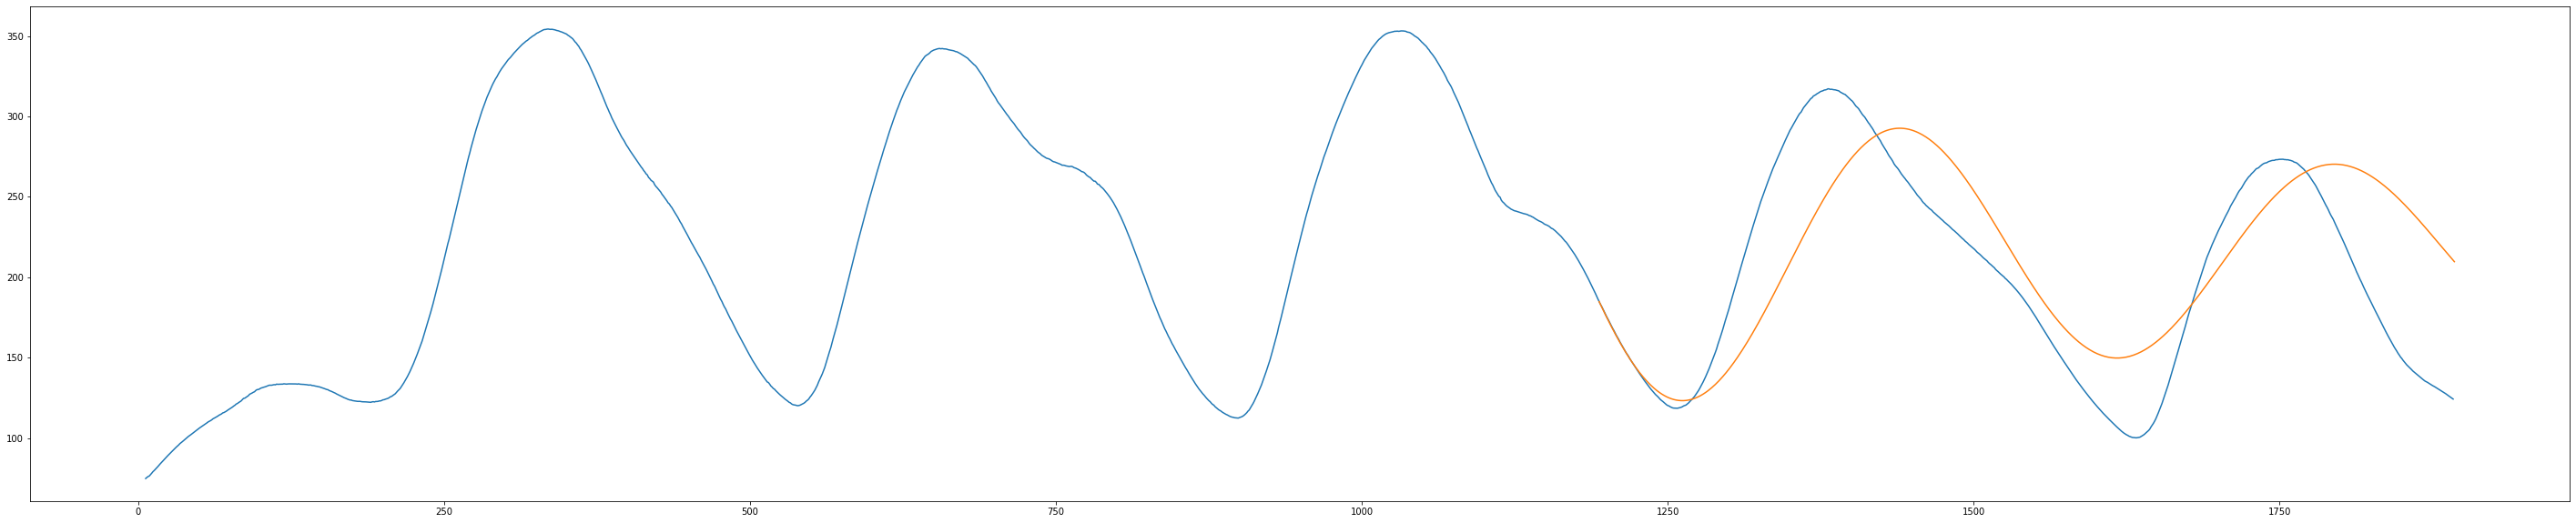

36.4988021230228


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


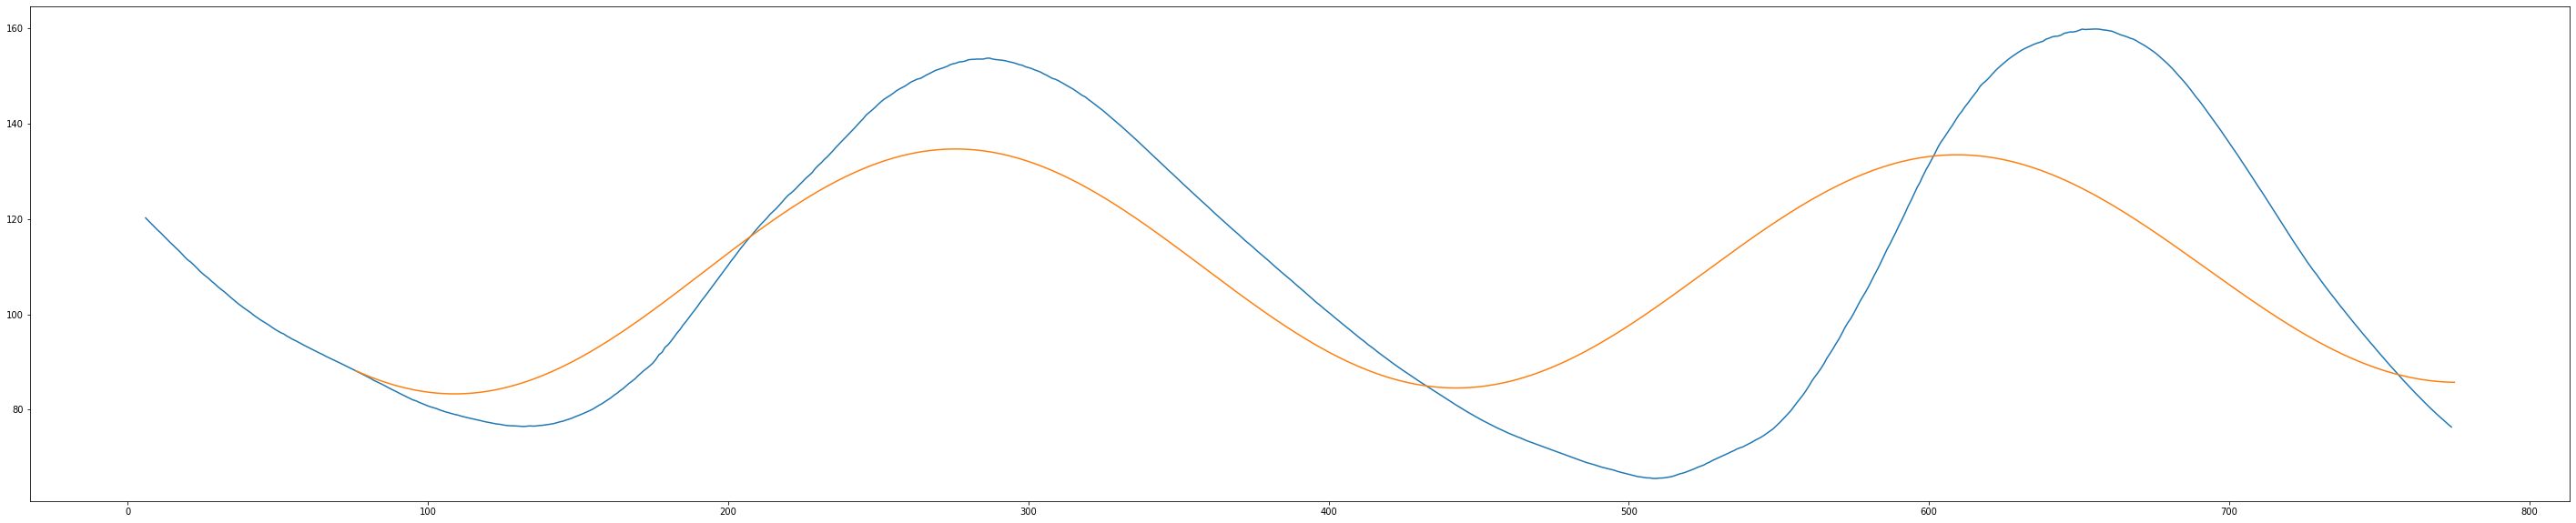

16.596840468644277
The average of all mean_absolute_error values is:  35.76339770909358


In [ ]:
#(E) Using ARMA
from matplotlib import pyplot as plt 

map = None
def Split(data):
    answers = []
    for i in range(7):
        data[i].replace(0, np.nan, inplace=True)
    
    for i in range(7):
        #We are only doing it for one city at the moment
        datatemp = data.copy()
        datatemp = datatemp.dropna(subset=[i]) 
        ARMA(datatemp, i, answers)

def Rolling(data):
  lens = len(data[20])
  data = np.asarray(data)
  #Rolling is 7 day average, the first six rows wouldn't have have full seven day coverage so we start from 6
  for i in range(6, lens):
    data[i][20] = (data[i-6][20] + data[i-5][20] + data[i-4][20] + data[i-3][20] + data[i-2][20] + data[i-1][20] + data[i][20])/7
    
  data = pd.DataFrame(data)
  return data


def ARMA(data, i, answers):    
    import statsmodels.api as sm  

    data = data.reset_index()
    #The first six weren't averaged so we take them out 
    data = data.loc[6:, 20]
    #We'll predict for the last 700 rows for each city, we don't use train_split cause linear data needed
    y_test = data.iloc[-700: ]
    data = data.astype(float)
    start = len(data) - 699
    end = len(data)
    if(i == 0):
      #There are outliers in the first few rows of this data so we eliminate them first
      data = data.loc[100:]
      model = sm.tsa.ARMA(data, order = (2, 2))
      model = model.fit()
      y_pred = model.predict(start, end, dynamic=True)
      ax = data.plot(figsize=(50,10))
      map = y_pred.plot(ax = ax)
      plt.show()
      a = mean_absolute_error(y_pred, y_test)
      print(a)
      answers.append(a)
    
    if(i > 0):
      model = sm.tsa.ARMA(data, order = (2, 2))
      model = model.fit()
      y_pred = model.predict(start, end, dynamic=True)
      ax1 = data.plot(figsize=(50,10))
      map = y_pred.plot(ax = ax1)
      plt.show()
      a = mean_absolute_error(y_pred, y_test)
      print(a)
      answers.append(a)
    
    if(i == 6):
      print("The average of all mean_absolute_error values is: ", np.mean(answers))

data13 = datasave.copy()
#We only drop the data which doesn't have output, as ARMA only uses those values
data13 = data13.dropna(subset=[20])
#As our original has a lot of spikes on a daily basis, we take the Rolling value (7 day average) and smoothen the graph
data13 = Rolling(data13)
data13 = Rolling(data13)
data13 = Rolling(data13)
Split(data13)

In [ ]:
#(F) Using Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import initializers
from keras import optimizers
from keras import regularizers
  
def DeepLearningHalf(data):
    x = data.drop(columns=20)
    y = data.loc[:, 20]
    y = y.astype('int')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

    model = Sequential()
    model.add(Dense(512, input_dim=20, activation='relu', kernel_initializer="he_uniform"))
    model.add(Dense(512, activation='relu', kernel_initializer="he_uniform"))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer='Adam', loss='MeanAbsolutePercentageError', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=500, batch_size=80, validation_split=0.2)
    model.evaluate(x_train, y_train)
    y_pred = model.predict(x_test)
    print(mean_absolute_error(y_test, y_pred))

data14 = data7.copy()
DeepLearningHalf(data14)



Epoch 1/500
23/23 [==============================] - 1s 18ms/step - loss: 27.3280 - accuracy: 0.0000e+00 - val_loss: 17.7381 - val_accuracy: 0.0000e+00
Epoch 2/500
23/23 [==============================] - 0s 9ms/step - loss: 12.8889 - accuracy: 0.0000e+00 - val_loss: 10.7516 - val_accuracy: 0.0000e+00
Epoch 3/500
23/23 [==============================] - 0s 9ms/step - loss: 11.4947 - accuracy: 0.0000e+00 - val_loss: 10.1939 - val_accuracy: 0.0000e+00
Epoch 4/500
23/23 [==============================] - 0s 9ms/step - loss: 11.4759 - accuracy: 0.0000e+00 - val_loss: 11.4520 - val_accuracy: 0.0000e+00
Epoch 5/500
23/23 [==============================] - 0s 10ms/step - loss: 10.6210 - accuracy: 0.0000e+00 - val_loss: 9.9451 - val_accuracy: 0.0000e+00
Epoch 6/500
23/23 [==============================] - 0s 9ms/step - loss: 10.9134 - accuracy: 0.0000e+00 - val_loss: 11.0844 - val_accuracy: 0.0000e+00
Epoch 7/500
23/23 [==============================] - 0s 8ms/step - loss: 10.7164 - accuracy: 

In [ ]:
def DeepLearningFull(data):
    x = data.drop(columns=20)
    y = data.loc[:, 20]
    y = y.astype('int')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)
    
    model = Sequential()
    model.add(Dense(512, input_dim=20, activation='relu', kernel_initializer="he_uniform", kernel_regularizer = regularizers.l1(0.01)))
    #model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer="he_uniform", kernel_regularizer = regularizers.l1(0.01)))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu', kernel_initializer="he_uniform"))

    model.compile(optimizer='Adam', loss='MeanAbsolutePercentageError', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=500, batch_size=80, validation_split=0.2)
    model.evaluate(x_train, y_train)
    y_pred = model.predict(x_test)
    print(mean_absolute_error(y_test, y_pred))
    
data15 = data6.copy()
data15 = np.asarray(data15).astype('float32')
data15 = pd.DataFrame(data15)
DeepLearningFull(data15)

Epoch 1/500
87/87 [==============================] - 2s 11ms/step - loss: 143.9661 - accuracy: 0.0000e+00 - val_loss: 105.6277 - val_accuracy: 0.0000e+00
Epoch 2/500
87/87 [==============================] - 1s 9ms/step - loss: 90.1468 - accuracy: 0.0000e+00 - val_loss: 80.6118 - val_accuracy: 0.0000e+00
Epoch 3/500
87/87 [==============================] - 1s 9ms/step - loss: 74.2143 - accuracy: 0.0000e+00 - val_loss: 68.6305 - val_accuracy: 0.0000e+00
Epoch 4/500
87/87 [==============================] - 1s 9ms/step - loss: 64.5039 - accuracy: 0.0000e+00 - val_loss: 62.0802 - val_accuracy: 0.0000e+00
Epoch 5/500
87/87 [==============================] - 1s 9ms/step - loss: 57.3546 - accuracy: 0.0000e+00 - val_loss: 56.2864 - val_accuracy: 0.0000e+00
Epoch 6/500
87/87 [==============================] - 1s 9ms/step - loss: 51.8671 - accuracy: 0.0000e+00 - val_loss: 51.2403 - val_accuracy: 0.0000e+00
Epoch 7/500
87/87 [==============================] - 1s 9ms/step - loss: 48.7445 - accuracy

In [ ]:
#(G) Using Stacking
def StackingPart1(data, i):
    from sklearn.linear_model import LinearRegression
    from sklearn.svm import SVR
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import GridSearchCV
    x = data.drop(columns = 20)
    y = data.loc[:, 20]
    y = y.astype('int')
    train, val_train, test, val_test = train_test_split(x, y, test_size = 0.5, random_state = 1)
    x_train, x_test, y_train, y_test = train_test_split(train, test, test_size = 0.2, random_state = 1)

    Linears = LinearRegression()
    Linears.fit(x_train, y_train)
    svr = SVR(kernel='linear', C = 1, gamma = 500)
    svr.fit(x_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(x_train, y_train)
    if(i == 'Half'):
      model = Sequential()
      model.add(Dense(512, input_dim=20, activation='relu', kernel_initializer="he_uniform"))
      model.add(Dense(512, activation='relu', kernel_initializer="he_uniform"))
      model.add(Dense(1, activation='relu'))
      model.compile(optimizer='Adam', loss='MeanAbsolutePercentageError', metrics=['accuracy'])
      model.fit(x_train, y_train, epochs=500, batch_size=80, validation_split=0.2, verbose = 0)
      clf = DecisionTreeClassifier(criterion= 'gini', max_depth = 6, min_samples_leaf = 9, min_samples_split = 2, splitter = 'best')
      clf.fit(x_train, y_train)

    if(i == 'Full'):
      model = Sequential()
      model.add(Dense(512, input_dim=20, activation='relu', kernel_initializer="he_uniform", kernel_regularizer = regularizers.l1(0.01)))
      model.add(Dense(512, activation='relu', kernel_initializer="he_uniform", kernel_regularizer = regularizers.l1(0.01)))
      model.add(Dense(1, activation='relu', kernel_initializer="he_uniform"))
      model.compile(optimizer='Adam', loss='MeanAbsolutePercentageError', metrics=['accuracy'])
      model.fit(x_train, y_train, epochs=500, batch_size=80, validation_split=0.2, verbose = 0)
      clf = DecisionTreeClassifier()
      clf.fit(x_train, y_train)  
    
    pred_val1 = Linears.predict(val_train)
    pred_val1 = np.reshape(pred_val1, (-1, 1))
    pred_val2 = svr.predict(val_train)
    pred_val2 = np.reshape(pred_val2, (-1, 1))
    pred_val3 = knn.predict(val_train)
    pred_val3 = np.reshape(pred_val3, (-1, 1))
    pred_val4 = model.predict(val_train)
    pred_val5 = clf.predict(val_train)
    pred_val5 = np.reshape(pred_val5, (-1, 1))

    pred_test1 = Linears.predict(x_test)
    pred_test1 = np.reshape(pred_test1, (-1, 1))
    pred_test2 = svr.predict(x_test)
    pred_test2 = np.reshape(pred_test2, (-1, 1))
    pred_test3 = knn.predict(x_test)
    pred_test3 = np.reshape(pred_test3, (-1, 1))
    pred_test4 = model.predict(x_test)
    pred_test5 = clf.predict(x_test)
    pred_test5 = np.reshape(pred_test5, (-1, 1))

    pred_val = np.concatenate((pred_val1, pred_val2, pred_val3, pred_val4, pred_val5), axis=1)
    pred_test = np.concatenate((pred_test1, pred_test2, pred_test3, pred_test4, pred_test5), axis=1)

    return pred_val, pred_test, val_test, y_test
    

data16 = data7.copy()
pred_val1, pred_test1, val_test1, y_test1 = StackingPart1(data16, "Half")

data17 = data6.copy()
data17 = np.asarray(data17).astype('float32')
data17 = pd.DataFrame(data17)
pred_val2, pred_test2, val_test2, y_test2 = StackingPart1(data17, "Full")

In [ ]:
def StackingPart2Half(pred_val, pred_test, val_test, y_test):
    from sklearn.ensemble import RandomForestClassifier

    """
    grid_param = {
        "n_estimators": [5, 10],
        "criterion": ['gini', 'entropy'],
        "max_depth": range(2, 20, 4),
        "min_samples_leaf": range(1, 10, 2),
        "min_samples_split": range(2, 10, 2),
        "max_features": ['auto', 'log2']
    }

    grid_search = GridSearchCV(estimator=rand_clf, param_grid = grid_param, cv = 5, verbose=3)
    grid_search.fit(pred_val, val_test)
    best_parameters = grid_search.best_params_
    print(best_parameters)
    """
    #We use the best parameters we got from Grid Search
    rand_clf = RandomForestClassifier(n_estimators = 5, criterion = 'gini', max_depth = 6, max_features = 'log2', min_samples_leaf = 5, min_samples_split = 8)
    rand_clf.fit(pred_val, val_test)
    y_pred_test = rand_clf.predict(pred_test)
    print(mean_absolute_error(y_pred_test, y_test))

def StackingPart2Full(pred_val, pred_test, val_test, y_test):
    from sklearn.ensemble import RandomForestClassifier

    """
    grid_param = {
        "n_estimators": [5, 10],
        "criterion": ['gini', 'entropy'],
        "max_depth": range(2, 20, 4),
        "min_samples_leaf": range(1, 10, 2),
        "min_samples_split": range(2, 10, 2),
        "max_features": ['auto', 'log2']
    }

    grid_search = GridSearchCV(estimator=rand_clf, param_grid = grid_param, cv = 5, verbose=3)
    grid_search.fit(pred_val, val_test)
    best_parameters = grid_search.best_params_
    print(best_parameters)
    """
    
    #We use the best parameters we got from Grid Search
    rand_clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', max_depth = 6, max_features = 'log2', min_samples_leaf = 5, min_samples_split = 2)
    rand_clf.fit(pred_val, val_test)
    y_pred_test = rand_clf.predict(pred_test)
    print(mean_absolute_error(y_pred_test, y_test))
    
print("Using Stacking, the mean absolute error for using Half dataset is given by: ")
StackingPart2Half(pred_val1, pred_test1, val_test1, y_test1)

print("Using Stacking, the mean absolute error for using Full dataset is given by: ")
StackingPart2Full(pred_val2, pred_test2, val_test2, y_test2)

Using Stacking, the mean absolute error for using Half dataset is given by: 
15.417543859649124
Using Stacking, the mean absolute error for using Full dataset is given by: 
32.262766945218196
